In [103]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt

In [104]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device =" , device)

Using device = mps


In [105]:
df = pd.read_csv('https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [106]:
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [107]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [109]:
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [111]:
X_train_tensor = torch.from_numpy(X_train).float()  # converts to float32
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)  # make column vector
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

In [112]:
print(X_train_tensor.shape)  # should be (n_samples, n_features)
print(y_train_tensor.shape)  # should be (n_samples, 1)
print(y_train_tensor.dtype)  # should be torch.float32

torch.Size([455, 30])
torch.Size([455, 1])
torch.float32


In [113]:
class SimpleANN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 18)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(18, 10)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        z1 = self.linear(features)
        a1 = self.relu(z1)

        z2 = self.linear2(a1)
        a2 = self.relu(z2)

        z3 = self.linear3(a2)
        y_pred = self.sigmoid(z3)

        return y_pred

In [114]:
model = SimpleANN(X_train_tensor.shape[1])

# model(X_train_tensor)

In [115]:
model.linear.weight[:1]
model.linear.weight.shape
# model.linear2.weight[:1]
# model.linear2.weight.shape
# model.linear.bias

torch.Size([18, 30])

In [116]:
criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [117]:
# Forward pass
y_pred = model(X_train_tensor)

# Compute loss
loss = criterion(y_pred, y_train_tensor)

print("Initial loss:", loss.item())

Initial loss: 0.7272263765335083


Epoch [10/70], Loss: 0.7272
len(train_losses): 10
len(val_losses): 10
Epoch [20/70], Loss: 0.7272
len(train_losses): 20
len(val_losses): 20
Epoch [30/70], Loss: 0.7272
len(train_losses): 30
len(val_losses): 30
Epoch [40/70], Loss: 0.7272
len(train_losses): 40
len(val_losses): 40
Epoch [50/70], Loss: 0.7272
len(train_losses): 50
len(val_losses): 50
Epoch [60/70], Loss: 0.7272
len(train_losses): 60
len(val_losses): 60
Epoch [70/70], Loss: 0.7272
len(train_losses): 70
len(val_losses): 70


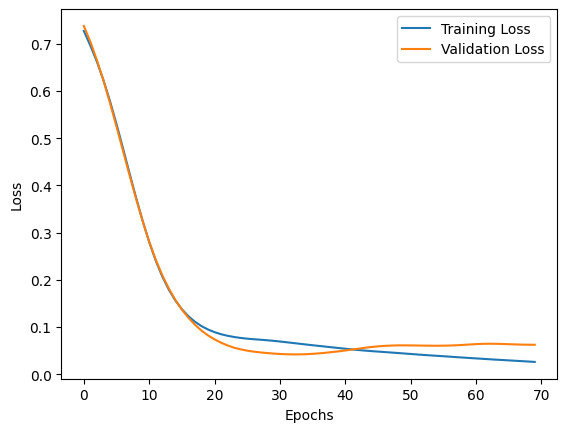

In [118]:
# running the loop
epochs = 70
train_losses = []
val_losses = []

for epoch in range(epochs):
    # 1. Forward pass
    model.train()
    y_pred = model(X_train_tensor)
    
    # 2. Compute loss
    train_loss = criterion(y_pred, y_train_tensor)

    # 3. Backpropagation
    optimizer.zero_grad()
    train_loss.backward()

    # 4. Update weights
    optimizer.step()

    train_losses.append(train_loss.item())


    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        print("len(train_losses):", len(train_losses))
        print("len(val_losses):", len(val_losses))


plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

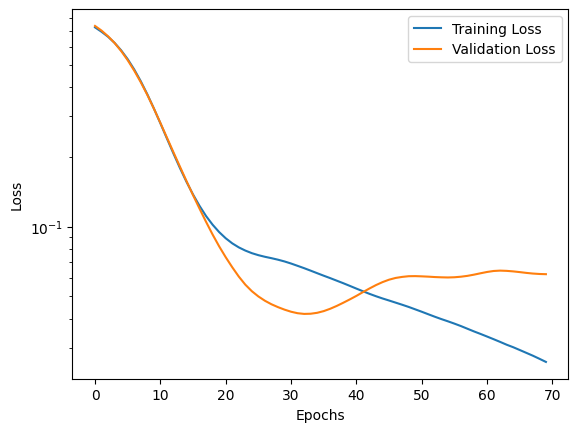

In [119]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
